In [1]:
import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [34]:
sampling_resolution = 10

### Load in GeoFabrics Bathymetry estimates

In [36]:
cache_path = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\caches\6374000000_new")
widths = geopandas.read_file(cache_path / "river_characteristics.geojson")
depths = geopandas.read_file(cache_path / "river_bathymetry.geojson")
main_channel = geopandas.read_file(cache_path / "rec_channel_6374000000.geojson")

### Specify GeoFabric parameter
Both the column names used in calculations, and also select parameter file values

In [37]:
water_elevation_name = 'min_z_centre_unimodal'
full_width_name = 'widths_mean_0.25km'
flat_width_name = 'flat_widths_mean_0.25km'
threshold_name = 'thresholds_mean_0.25km'
rupp_bed_elevation_name = 'bed_elevation_Rupp_and_Smart'
neal_bed_elevation_name = 'bed_elevation_Neal_et_al'
min_bank_height= 2
rupp_depth_name = 'bed_depth_Rupp_and_smart'
neal_depth_name = 'bed_depth_Neal_et_al'

#### Calculate depths from bed elevation

depths[rupp_bed_elevation_name].plot()

In [38]:
depths[rupp_depth_name] = widths[water_elevation_name]-depths[rupp_bed_elevation_name]
depths[neal_depth_name] = widths[water_elevation_name]-depths[neal_bed_elevation_name]

widths[[full_width_name, flat_width_name]].plot(ax=ax);

f, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15,6))
widths[[full_width_name, flat_width_name]].plot(ax=ax)

f, ax = matplotlib.pyplot.subplots(1, 1, sharey=True, figsize=(15,6))
widths[water_elevation_name].plot(ax=ax)
depths[neal_bed_elevation_name].plot(ax=ax)
depths[rupp_bed_elevation_name].plot(ax=ax)

#### Convert back to full bankfill area
Function to do the conversion

In [39]:
def to_full_bank_flow_area(depth_dataframe, width_dataframe, min_bank_height, threshold_name, full_width_name, flat_width_name, depth_name, water_elevation_name):
    
    # backwards calculate the 'flat water area' - note this is in error as didn't remove most of threshold area
    non_flood_area = depth_dataframe[depth_name] * width_dataframe[flat_width_name]

    # flood area
    exposed_bank_area = (width_dataframe[full_width_name] - width_dataframe[flat_width_name]) \
        * (width_dataframe[threshold_name] - min_bank_height)
    flood_area = width_dataframe[full_width_name] * width_dataframe[threshold_name] - exposed_bank_area
    
    # Calculate the area estimated for full bank width flow
    full_bank_area = non_flood_area + flood_area

    return non_flood_area, full_bank_area
    

### Plot full bank flow area and flat water area
For Rupp and Smart

In [40]:
flat_water_area, full_bank_area = to_full_bank_flow_area(depth_dataframe=depths,
                                                         width_dataframe=widths,
                                                         min_bank_height=min_bank_height,
                                                         threshold_name=threshold_name,
                                                         full_width_name=full_width_name,
                                                         flat_width_name=flat_width_name,
                                                         depth_name=rupp_depth_name,
                                                         water_elevation_name=water_elevation_name)
areas = pandas.concat([flat_water_area, full_bank_area], keys=['flat_water_area', 'full_bank_area'], axis=1)

<AxesSubplot:>

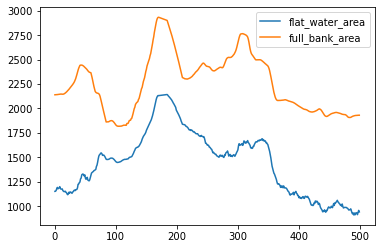

In [41]:
areas.plot()

## Load in Measured cross sections
load in files including a raster for performing a local dataum conversion

In [42]:
cross_section_file = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Westport/3738_Buller_River_October_2021/3738_Buller_River_October_2021.shp")
cross_section_file_2 = pathlib.Path(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Westport/3738 - Buller River October 2021.xls")
cross_sections = geopandas.read_file(cross_section_file)
cross_section_elevation_label = 'Elevation'
cross_section_name_label = 'Name'

Manually specify order of sections and manually remove sections across side-channels. Note could try automate by working down the centreline and checking each section for any intersections with the measured sections

In [43]:
ordered_measured_sections = ['Section2', 'Section2A', 'Section2B', 'Section3', 'Section3A', 'Section4', 'Section5', 'Section6',
                             'Section7', 'Section8', 'Section9', 'Section10', 'Section11', 'Section12', 'Section13', 'Section14',
                             'Section15', 'Section16', 'Section21', 'Section22', 'Section23', 'Section24', 'Section25', 'Section26']

Note that the data is noisey and four sections are on a side channel: sections 17, 18, 19, 20

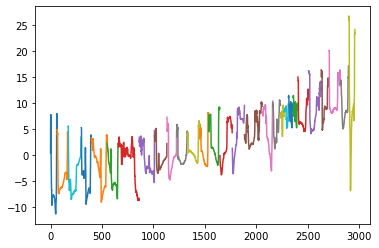

In [44]:
cross_sections.groupby(cross_section_name_label)[cross_section_elevation_label].plot();

### Perform LVD to NZVD2016 conversion

In [47]:
local_datum_file = pathlib.Path(r"C:\Users\pearsonra\Documents\data\local_datums\lds-lyttelton-1937-to-nzvd2016-conversion-raster-GTiff\lyttelton-1937-to-nzvd2016-conversion-raster.tif")

import rioxarray
local_vertical_datum = rioxarray.rioxarray.open_rasterio(local_datum_file, masked=True)

In [49]:
def get_lvd_conversion(geometry, local_vertical_datum):
    return local_vertical_datum.sel({'x': [geometry.x], 'y': [geometry.y]}, method='nearest').data[0,0,0]

cross_sections['lvd_conversion'] = cross_sections.apply(lambda row: get_lvd_conversion(row.geometry, local_vertical_datum), axis=1)
cross_sections['z_2016'] = cross_sections[cross_section_elevation_label] - cross_sections['lvd_conversion']

### Get nearest estimated to measured cross section
Make cross sections geometries

In [119]:
section_centres = {'Section': [], 'geometry': []}
for section in cross_sections[cross_section_name_label].unique():
    cross_section = cross_sections[cross_sections[cross_section_name_label] == section]
    section_centre = cross_section[cross_section['Elevation']==cross_section['Elevation'].min()].iloc[0]
    section_centres['Section'].append(section_centre[cross_section_name_label])
    section_centres['geometry'].append(section_centre['geometry'])
section_centres = geopandas.GeoDataFrame(section_centres, crs=main_channel.crs)

Cycle through each section identifying the nearest section in the key parameters

In [120]:
nearest_cross_sections = numpy.zeros_like(widths[water_elevation_name], dtype=bool)
nearest_sections_ids = numpy.zeros_like(widths[water_elevation_name], dtype=object)
for index, row in section_centres.iterrows():
    nearest_cross_sections[widths.distance(row.geometry).argmin()] = True
    nearest_sections_ids[widths.distance(row.geometry).argmin()] = row['Section']

nearest_widths = widths[nearest_cross_sections]
nearest_depths = depths[nearest_cross_sections]
nearest_areas = areas[nearest_cross_sections]
nearest_widths.insert(loc=0, column='Section', value=nearest_sections_ids[nearest_cross_sections])
nearest_depths.insert(loc=0, column='Section', value=nearest_sections_ids[nearest_cross_sections])

Calculate the measured 'depth' based on the water surface in the LiDAR 

In [121]:
cross_sections[water_elevation_name] = cross_sections.apply(lambda row: nearest_widths[nearest_widths['Section'] == row[cross_section_name_label]][water_elevation_name].mean(), axis=1)
cross_sections['depth'] = cross_sections[water_elevation_name] - cross_sections['z_2016']

### Calculate cross sectional area of each profile
From flat water height, and also the bank-full height. Cycle through sections taking each section.

_Could add a check to ensure no gap - i.e. portion of the channel above water then below again - but won't as could be two channels_

#### Initial estimate 
Calculate the Riemann squares centred sections entirely less than water surface. 

In [122]:
measured_area = []
for index, row in nearest_widths.iterrows():
    section = cross_sections[cross_sections[cross_section_name_label] == row['Section']]
    section = section[section['depth'] > 0]
    calculated_dx = (section['North'].rolling(window=2).apply(numpy.diff) ** 2 + section['East'].rolling(window=2).apply(numpy.diff) ** 2) **(1/2)
    measured_area.append((calculated_dx
      * (section['depth']).rolling(window=2).apply(numpy.mean)).iloc[1:].sum())
nearest_areas.insert(loc=0, column='Measured areas crude', value=measured_area)

#### Calculated propely
Calculate area from where each section goes below the water surface (even if between two measurement sites)

In [97]:
def zero_crossing(x_pos: float, x_neg: float, y_pos: float, y_neg: float):
    x_zc = x_pos * -y_neg / (y_pos - y_neg) + x_neg * y_pos / (y_pos - y_neg)
    return x_zc

In [127]:
measured_area = []

for index, row in nearest_widths.iterrows():
    section = cross_sections[cross_sections[cross_section_name_label] == row['Section']]
    section = section.reset_index(drop=True)
    water_elevation = row[water_elevation_name]
    area = 0
    for i in range(len(section) - 1):
        if section['depth'][i] >= 0 and section['depth'][i + 1] >= 0:
            # Caclulate distance between depth measurements
            segment_length = ((section['North'][i + 1] - section['North'][i]) ** 2 + (section['East'][i + 1] - section['East'][i]) ** 2) **(1/2)
            # calculate Raimann square area
            area += segment_length * (section['depth'][i] + section['depth'][i + 1]) / 2
        elif section['depth'][i] > 0:
            # Caclulate distance between depth measurements
            segment_length = ((section['North'][i + 1] - section['North'][i]) ** 2 + (section['East'][i + 1] - section['East'][i]) ** 2) **(1/2)
            # Calculate from the left - right is above
            offset_crossing = zero_crossing(x_pos=segment_length, x_neg=0,
                                            y_pos=section['depth'][i + 1], y_neg=section['depth'][i]) 
            area += (offset_crossing - section['Offset'][i]) * section['depth'][i] / 2
        elif section['depth'][i + 1] > 0:
            # Caclulate distance between depth measurements
            segment_length = ((section['North'][i + 1] - section['North'][i]) ** 2 + (section['East'][i + 1] - section['East'][i]) ** 2) **(1/2)
            # Calculate from the right - left is above
            offset_crossing = zero_crossing(x_pos=0, x_neg=segment_length,
                                            y_pos=section['depth'][i], y_neg=section['depth'][i + 1]) 
            area += (section['Offset'][i + 1] - offset_crossing) * section['depth'][i + 1] / 2
    measured_area.append(area)
nearest_areas.insert(loc=0, column='Measured areas exact', value=measured_area)

<AxesSubplot:>

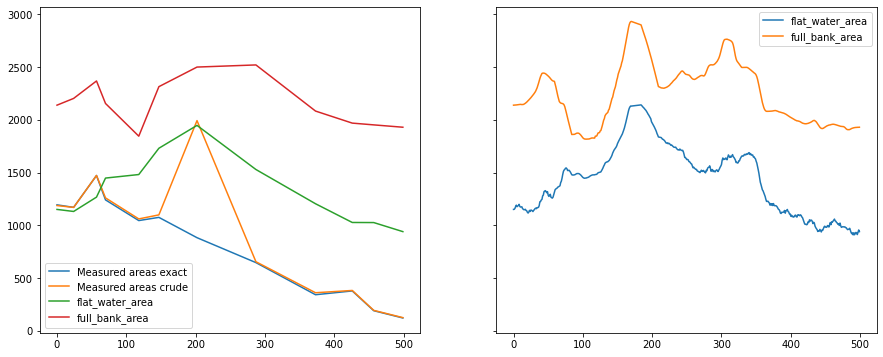

In [128]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
areas.plot(ax=axs[1])

<AxesSubplot:>

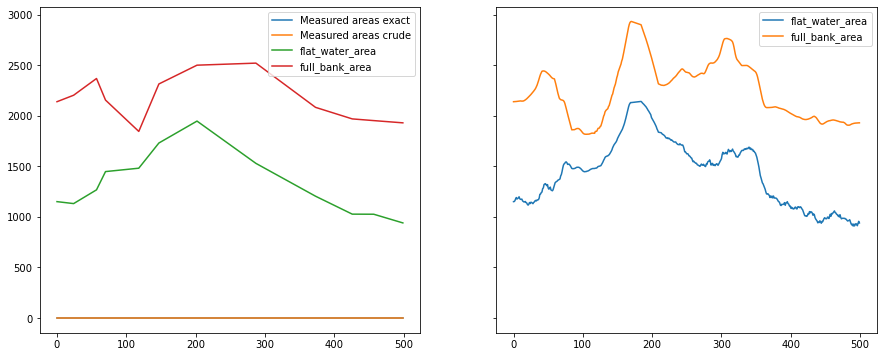

In [72]:
f, axs = matplotlib.pyplot.subplots(1, 2, sharey=True, figsize=(15,6))
nearest_areas.plot(ax=axs[0])
cross_section_name_label.plot(ax=axs[1])

In [75]:
nearest_areas.head()

,Measured areas exact,Measured areas crude,flat_water_area,full_bank_area
0,0,0.0,1150.681280,2139.072631
24,0,0.0,1131.336548,2203.066285
57,0,0.0,1267.286939,2368.473466
70,0,0.0,1447.884864,2155.087642
118,0,0.0,1481.422021,1845.126758


## Plot bed elevations and depths of the two approaches

In [ ]:
f, axs = matplotlib.pyplot.subplots(1, 2, figsize=(15, 6))

nearest_widths.set_index('Section', drop=True)[water_elevation_name].plot(ax=axs[0], label='Water surface elevation')
nearest_depths.set_index('Section', drop=True)['bed_elevation_Neal_et_al'].plot(ax=axs[0], label='Bed elevation calculated Neal et al')
nearest_depths.set_index('Section', drop=True)['bed_elevation_Rupp_and_Smart'].plot(ax=axs[0], label='Bed elevation calculated Rupp & Smart')
cross_sections.groupby('Section')['z_2016'].min().plot(ax=axs[0], label='Measured cross-section')
axs[0].set(title="Bed elevations estimated and measured", xlabel="Transect number where there are measured cross sections", ylabel="River bed elevation in m")
axs[0].legend()

nearest_depths.set_index('Section', drop=True)[neal_depth_name].plot(ax=axs[1], label='Calculated Neal et al depth')
nearest_depths.set_index('Section', drop=True)[rupp_depth_name].plot(ax=axs[1], label='Calculated Rupp & Smart depth')
cross_sections.groupby('Section')['depth'].max().plot(ax=axs[1], label='Measured cross-section')
axs[1].set(title="Bed depths estimated and measured", xlabel="Transect number where there are measured cross sections", ylabel="River depths in m")
axs[1].legend()

## Plot cross sections

In [ ]:
cross_sections[[water_elevation_name, 'z_2016']].plot(figsize=(15, 6))
matplotlib.pyplot.yticks(ticks=[-2.5, 0, 2.5, 10, 20, 30, 40]);
matplotlib.pyplot.grid(axis="y")

In [ ]:
f, axs = matplotlib.pyplot.subplots(2, 4, figsize=(30, 12), sharey=True)
for key, group in cross_sections.groupby('Section'):
    (-group['depth']).reset_index(drop=True).plot(ax=axs[int(key/10/28), int((key/10 - 28)/7)], label=f"{key}")
for axi in axs:
    for axij in axi:
        axij.legend()

In [ ]:
f, axs = matplotlib.pyplot.subplots(2, 4, figsize=(30, 12), sharey=True)

for key, group in cross_sections.groupby('Section'):
    group = group.copy(deep=True)
    group.loc[group['depth'] < 0, 'depth'] = numpy.nan
    (-group['depth']).reset_index(drop=True).plot(ax=axs[int(key/10/28), int((key/10 - 28)/7)], label=f"{key}")
    #print(f"key={key}, f{group['depth'].values}")
for axi in axs:
    for axij in axi:
        axij.legend()

In [ ]:
cross_sections.groupby('Section')['depth'].plot();

In [ ]:
cross_sections.groupby('Section')['z_2016'].plot();

### Plots exploring the change to width to produce an expected bed elevation

In [ ]:
fudge_factor = 2
depth_wider = (nearest_key_parameters['mannings_n'] * nearest_key_parameters['flow'] / (numpy.sqrt(nearest_key_parameters['slope']) * nearest_key_parameters['widths_Savgol'] * fudge_factor)) ** (3/5) - threshold

f, ax = matplotlib.pyplot.subplots(figsize=(20, 6))
(nearest_key_parameters['min_z_centre_unimodal']-depth_wider).reset_index(drop=True).plot(label='Calculated from unimodal min_z')
(nearest_key_parameters['min_z_centre_unimodal_0.5km_rolling_mean'] - depth_wider).reset_index(drop=True).plot(label='Calculated from smooth unimodal min_z')
(nearest_key_parameters['min_z_centre']-depth_wider).reset_index(drop=True).plot(label='Calculated from min_z')
cross_sections.groupby('Section')['z_2016'].min().reset_index(drop=True).plot(label='Measured cross-section')
ax.set(title=f"Depths estimated using the Uniform Flow Throery approach with width mutiplier of {fudge_factor}")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River depth in m");
matplotlib.pyplot.legend()